### 라이브러리 불러오기

In [1]:
import pandas as pd
import pickle
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model, ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import BaggingRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn import preprocessing
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit

import joblib
import os
import warnings

warnings.filterwarnings('ignore')

def get_score(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return mae, mse, rmse, r2


In [2]:
# 데이터 불러오기
#data = pd.read_csv('2008~2023_data.csv', engine='python')
data = pd.read_parquet('2008~2023_data.parquet')

In [3]:
data.head()

,Date,Line_num,Station,Station_num,Time,holiday,weekday,geton,getoff,get_all,...,Snow_amt_mean,Rainfall_amt_sum,Snow_amt_sum,Temp_max,Temp_min,Temp_diff,hour,year,month,day
0,2008-01-01,1,서울역(150),150,00:00,1,2,264.0,558.0,822.0,...,0.0,0.0,0.0,-3.4,-8.3,4.9,0,2008,1,1
1,2008-01-01,1,시청(151),151,00:00,1,2,974.0,185.0,1159.0,...,0.0,0.0,0.0,-3.4,-8.3,4.9,0,2008,1,1
2,2008-01-01,1,종각(152),152,00:00,1,2,1559.0,210.0,1769.0,...,0.0,0.0,0.0,-3.4,-8.3,4.9,0,2008,1,1
3,2008-01-01,1,종로3가(153),153,00:00,1,2,1499.0,384.0,1883.0,...,0.0,0.0,0.0,-3.4,-8.3,4.9,0,2008,1,1
4,2008-01-01,1,종로5가(154),154,00:00,1,2,140.0,42.0,182.0,...,0.0,0.0,0.0,-3.4,-8.3,4.9,0,2008,1,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30239475 entries, 0 to 30239474
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Date               object 
 1   Line_num           int64  
 2   Station            object 
 3   Station_num        int64  
 4   Time               object 
 5   holiday            int64  
 6   weekday            int64  
 7   geton              float64
 8   getoff             float64
 9   get_all            float64
 10  Temp               float64
 11  Rainfall_amt       float64
 12  Wind_speed         float64
 13  Humidity           float64
 14  Snow_amt           float64
 15  Temp_mean          float64
 16  Rainfall_amt_mean  float64
 17  Wind_speed_mean    float64
 18  Humidity_mean      float64
 19  Snow_amt_mean      float64
 20  Rainfall_amt_sum   float64
 21  Snow_amt_sum       float64
 22  Temp_max           float64
 23  Temp_min           float64
 24  Temp_diff          float64
 25  hour            

### 데이터 사이즈가 너무 크기 때문에 샘플데이터를 통하여 모델 학습 진행

In [5]:
data = data[(data['year'] >= 2018) & (data['year'] <= 2023)]

### 파생변수 생성
- 비가 온날과 안온날 차이가 있었기 때문에 rainy 파생변수 생성

In [6]:
data['rainy'] = data['Rainfall_amt']>0.0
data['rainy'] = data['rainy'].astype(np.int32)

### 종속변수가 최대한 정규분포를 따라야 하고 이상치를 최소화 하기위해 로그 스케일링 진행

In [7]:
data['log_get_all'] = np.log1p(data['get_all'])

### 푸리에특징을 통한 시간연속성 표현(HOUR)
- 간단한 푸리에 변환을 활용하여, hour의 시간연속성을 데이터에 표현하였습니다.

In [8]:
def cyclical_encoding(x, max_val):
    sin_val = np.sin(2 * np.pi * x / max_val)
    cos_val = np.cos(2 * np.pi * x / max_val)
    return sin_val, cos_val

# hour 변수를 Cyclical Encoding으로 변환하여 대체하기
max_hour = 24
data['hour_sin'], data['hour_cos']= cyclical_encoding(data['hour'], max_hour)
data.drop('hour', axis=1, inplace=True)

# 결과 확인
data.head()

,Date,Line_num,Station,Station_num,Time,holiday,weekday,geton,getoff,get_all,...,Temp_max,Temp_min,Temp_diff,year,month,day,rainy,log_get_all,hour_sin,hour_cos
19688111,2018-01-01,1,서울역,150,00:00,1,1,96.0,147.0,243.0,...,3.7,-5.0,8.7,2018,1,1,0,5.497168,0.0,1.0
19688112,2018-01-01,1,시청,151,00:00,1,1,9.0,39.0,48.0,...,3.7,-5.0,8.7,2018,1,1,0,3.891820,0.0,1.0
19688113,2018-01-01,1,종각,152,00:00,1,1,28.0,33.0,61.0,...,3.7,-5.0,8.7,2018,1,1,0,4.127134,0.0,1.0
19688114,2018-01-01,1,종로3가,153,00:00,1,1,16.0,35.0,51.0,...,3.7,-5.0,8.7,2018,1,1,0,3.951244,0.0,1.0
19688115,2018-01-01,1,종로5가,154,00:00,1,1,8.0,28.0,36.0,...,3.7,-5.0,8.7,2018,1,1,0,3.610918,0.0,1.0


### 원핫인코딩 진행
- 범주형 데이터를 원핫인코딩을 진행하여 모델링 진행

In [9]:
# One-hot encoding
selected_columns = ['log_get_all', 'holiday', 'rainy', 'hour_sin', 'hour_cos','Temp','Rainfall_amt','Humidity','Wind_speed']
categorical_columns = ['Station_num', 'Line_num', 'weekday', 'month']

# Apply one-hot encoding to categorical columns
encoded_columns = []
for column in categorical_columns:
    encoded_df = pd.get_dummies(data[column], prefix=column, prefix_sep='_')
    encoded_columns.append(encoded_df)

# Encode the 'year' column separately
year_data = pd.get_dummies(data['year'], prefix='year', prefix_sep='_')
encoded_columns.append(year_data)

# Concatenate the selected columns and encoded columns
data_encoded = pd.concat([data[selected_columns]] + encoded_columns, axis=1)

### 훈련 데이터셋과 테스트 데이터셋 나누기
- 2018년부터 2021년까지의 데이터를 훈련 데이터로 사용하고, 2022년부터 2023년까지의 데이터를 테스트 데이터로 사용함. 이를 통해 모델은 과거 데이터를 기반으로 학습하여 미래의 데이터에 대해 예측 수행 할 수 있음.

In [10]:
# Specify the start and end years for training and testing
train_start_year = 2018
train_end_year = 2021
test_start_year = 2022
test_end_year = 2023

# Filter the data based on the years
train_data = data_encoded[(data['year'] >= train_start_year) & (data['year'] <= train_end_year)]
test_data = data_encoded[(data['year'] >= test_start_year) & (data['year'] <= test_end_year)]

# Separate the features (X) and target variable (Y)
X_train = train_data.drop(['log_get_all'], axis=1)
Y_train = train_data['log_get_all']
X_test = test_data.drop(['log_get_all'], axis=1)
Y_test = test_data['log_get_all']

### 모델 성능 비교
- Lasso, Ridge, ElasticNet, CatBoost, XGBoost, LGBM 모델 비교.
- Nested Cross validation를 사용하여, 외부 시계열 교차 검증과 내부 모델 검증을 통하여 모델의 일반화 성능 확인을 가능하게 합니다.


In [12]:
# Create a TimeSeriesSplit object for time series splitting
tscv = TimeSeriesSplit(n_splits=5)

# Variable initialization
log_mae_scores = []
mae_scores = []
train_scores = []
test_scores = []
r2_scores = []
train_r2_scores = []

# Create a list of models
models = [
    Lasso(random_state=42),
    Ridge(random_state=42),
    ElasticNet(random_state=42),
    CatBoostRegressor(random_state=42),
    XGBRegressor(random_state=42),
    LGBMRegressor(random_state=42)
]

# Initialize a list to store the results
results = []

# Outer loop: iterate over the time series segmentation
for train_index, test_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = Y_train.iloc[train_index], Y_train.iloc[test_index]

    # Inner loop: iterate over the models
    for model in models:
        model.fit(X_train_fold, y_train_fold)  # Train the model

        # Evaluate the model on the validation set
        y_pred = np.expm1(model.predict(X_val_fold))
        mae = mean_absolute_error(np.expm1(y_val_fold), y_pred)
        mae_scores.append(mae)

        # Evaluate the model on the training set
        train_pred = np.expm1(model.predict(X_train_fold))
        train_mae = mean_absolute_error(np.expm1(y_train_fold), train_pred)
        train_scores.append(train_mae)

        # Evaluate the model on the test set
        test_pred = np.expm1(model.predict(X_test))
        test_mae = mean_absolute_error(np.expm1(Y_test), test_pred)
        test_scores.append(test_mae)

        # Calculate R2 score on the training set
        train_r2 = r2_score(np.expm1(y_train_fold), train_pred)
        train_r2_scores.append(train_r2)

        # Calculate R2 score on the test set
        r2 = r2_score(np.expm1(Y_test), test_pred)
        r2_scores.append(r2)

        # Store the results in a dictionary
        result = {
            'Model': model.__class__.__name__,
            'MAE (CV)': mae,
            'MAE (Train)': train_mae,
            'MAE (Test)': test_mae,
            'R2 Score (Train)': train_r2,
            'R2 Score (Test)': r2
        }
        results.append(result)
        
        print(f'{model.__class__.__name__} 모델 학습 완료, TEST MAE: {test_mae}, TEST R2: {r2}')
        print('='*50)
        
# Create a DataFrame from the results
results_df = pd.DataFrame(results)
results_df


Lasso 모델 학습 완료, TEST MAE: 1000.0496548175266, TEST R2: -0.07894292048330209
Ridge 모델 학습 완료, TEST MAE: 733.0853781280844, TEST R2: 0.3783896697388598
ElasticNet 모델 학습 완료, TEST MAE: 996.9018096518291, TEST R2: -0.08160019444019295
Learning rate set to 0.127512
0:	learn: 1.0855931	total: 105ms	remaining: 1m 45s
1:	learn: 1.0331471	total: 146ms	remaining: 1m 12s
2:	learn: 0.9906138	total: 187ms	remaining: 1m 2s
3:	learn: 0.9555496	total: 229ms	remaining: 57s
4:	learn: 0.9240142	total: 273ms	remaining: 54.2s
5:	learn: 0.8993776	total: 311ms	remaining: 51.5s
6:	learn: 0.8777804	total: 347ms	remaining: 49.3s
7:	learn: 0.8569429	total: 388ms	remaining: 48.1s
8:	learn: 0.8413652	total: 425ms	remaining: 46.8s
9:	learn: 0.8264410	total: 460ms	remaining: 45.6s
10:	learn: 0.8124023	total: 493ms	remaining: 44.3s
11:	learn: 0.7990822	total: 535ms	remaining: 44s
12:	learn: 0.7872538	total: 574ms	remaining: 43.5s
13:	learn: 0.7765162	total: 615ms	remaining: 43.3s
14:	learn: 0.7673550	total: 649ms	remai

,Model,MAE (CV),MAE (Train),MAE (Test),R2 Score (Train),R2 Score (Test)
0,Lasso,1211.498289,1186.132463,1000.049655,-0.120831,-0.078943
1,Ridge,758.926517,768.555694,733.085378,0.499207,0.378390
2,ElasticNet,1209.339334,1183.340583,996.901810,-0.118006,-0.081600
3,CatBoostRegressor,257.113899,234.421306,390.495542,0.932182,0.818761
4,XGBRegressor,422.720453,399.179642,394.115101,0.847583,0.822342
5,LGBMRegressor,412.705568,397.045196,430.061633,0.839545,0.782966
6,Lasso,1210.444236,1198.915751,999.995606,-0.122549,-0.079714
7,Ridge,777.681057,769.451826,746.522694,0.501860,0.359967
8,ElasticNet,1204.900229,1195.567513,996.564128,-0.119547,-0.079633
9,CatBoostRegressor,238.136265,224.376545,390.639539,0.939723,0.823729


### 상위 3개 모델의 특성 중요도 확인
- CatBoost : 시간과 역이 특성 중요도에서 가장 높은 영향력을 보였으며, 호선과 공휴일도 영향력을 끼치는 것을 확인 할 수 있었음.
- XGBoost : 역에만 특성 중요도를 보였으며, 다른 변수는 영향력을 끼치는 것을 확인 할 수 없었음.
- LGBM : XGBoost와 마찬가지로 역이 가장 특성 중요도를 보였으며, 시간에도 영향력을 확인 할 수 있었으나 CatBoost에 비해 상당히 적은 것을 확인 할수 있었음.

Learning rate set to 0.169238
0:	learn: 1.0858057	total: 428ms	remaining: 7m 7s
1:	learn: 1.0224572	total: 753ms	remaining: 6m 15s
2:	learn: 0.9751054	total: 1.05s	remaining: 5m 48s
3:	learn: 0.9352929	total: 1.33s	remaining: 5m 31s
4:	learn: 0.9043107	total: 1.58s	remaining: 5m 15s
5:	learn: 0.8806157	total: 1.84s	remaining: 5m 4s
6:	learn: 0.8597172	total: 2.08s	remaining: 4m 55s
7:	learn: 0.8414217	total: 2.31s	remaining: 4m 46s
8:	learn: 0.8234706	total: 2.59s	remaining: 4m 45s
9:	learn: 0.8096115	total: 2.84s	remaining: 4m 41s
10:	learn: 0.7969645	total: 3.09s	remaining: 4m 37s
11:	learn: 0.7859451	total: 3.32s	remaining: 4m 33s
12:	learn: 0.7743331	total: 3.55s	remaining: 4m 29s
13:	learn: 0.7619231	total: 3.84s	remaining: 4m 30s
14:	learn: 0.7532825	total: 4.05s	remaining: 4m 25s
15:	learn: 0.7451894	total: 4.26s	remaining: 4m 22s
16:	learn: 0.7369221	total: 4.48s	remaining: 4m 19s
17:	learn: 0.7289519	total: 4.71s	remaining: 4m 17s
18:	learn: 0.7213916	total: 4.94s	remaining: 4

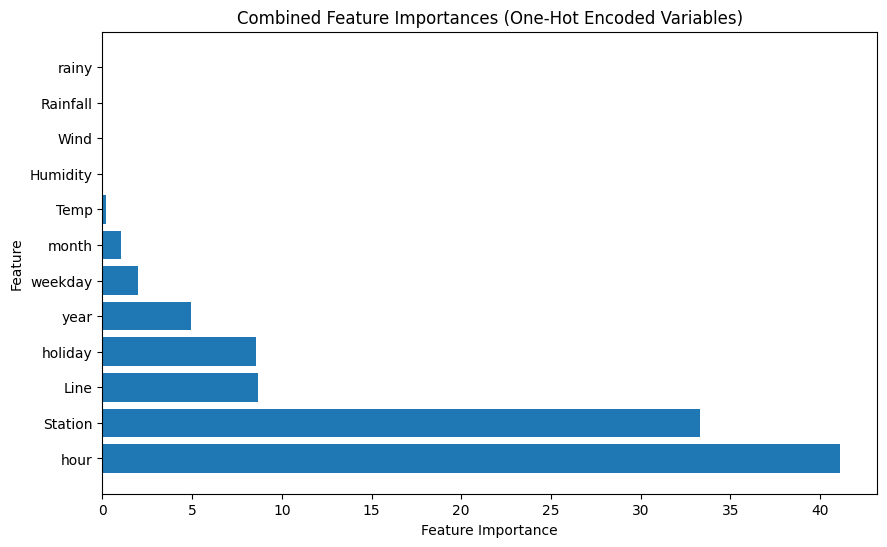

In [13]:
# Train the CatBoostRegressor model
catboost_model = CatBoostRegressor(random_state=42)
catboost_model.fit(X_train, Y_train)

# Get feature importances
feature_importances = catboost_model.get_feature_importance()

# Get original feature names (without one-hot encoding)
original_feature_names = [col.split('_')[0] for col in X_train.columns]

# Create a dictionary to store the combined feature importances
combined_feature_importances = {}

# Iterate over the feature importances and sum them for the original feature names
for feature_name, importance in zip(X_train.columns, feature_importances):
    original_feature_name = feature_name.split('_')[0]
    if original_feature_name in combined_feature_importances:
        combined_feature_importances[original_feature_name] += importance
    else:
        combined_feature_importances[original_feature_name] = importance

# Convert the combined feature importances dictionary to a DataFrame
importance_df = pd.DataFrame.from_dict(combined_feature_importances, orient='index', columns=['Importance'])
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(importance_df)), importance_df['Importance'], align='center')
plt.yticks(range(len(importance_df)), importance_df.index)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Combined Feature Importances (One-Hot Encoded Variables)')
plt.show()

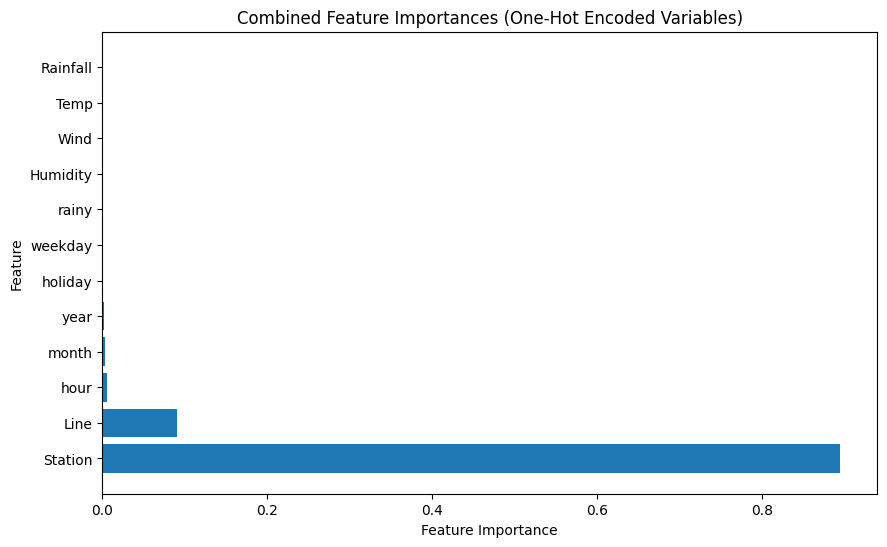

In [16]:
# Train the XGBRegressor model
xgboost_model = XGBRegressor(random_state=42)
xgboost_model.fit(X_train, Y_train)

# Get feature importances
feature_importances = xgboost_model.feature_importances_

# Get original feature names (without one-hot encoding)
original_feature_names = [col.split('_')[0] for col in X_train.columns]

# Create a dictionary to store the combined feature importances
combined_feature_importances = {}

# Iterate over the feature importances and sum them for the original feature names
for feature_name, importance in zip(X_train.columns, feature_importances):
    original_feature_name = feature_name.split('_')[0]
    if original_feature_name in combined_feature_importances:
        combined_feature_importances[original_feature_name] += importance
    else:
        combined_feature_importances[original_feature_name] = importance

# Convert the combined feature importances dictionary to a DataFrame
importance_df = pd.DataFrame.from_dict(combined_feature_importances, orient='index', columns=['Importance'])
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(importance_df)), importance_df['Importance'], align='center')
plt.yticks(range(len(importance_df)), importance_df.index)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Combined Feature Importances (One-Hot Encoded Variables)')
plt.show()

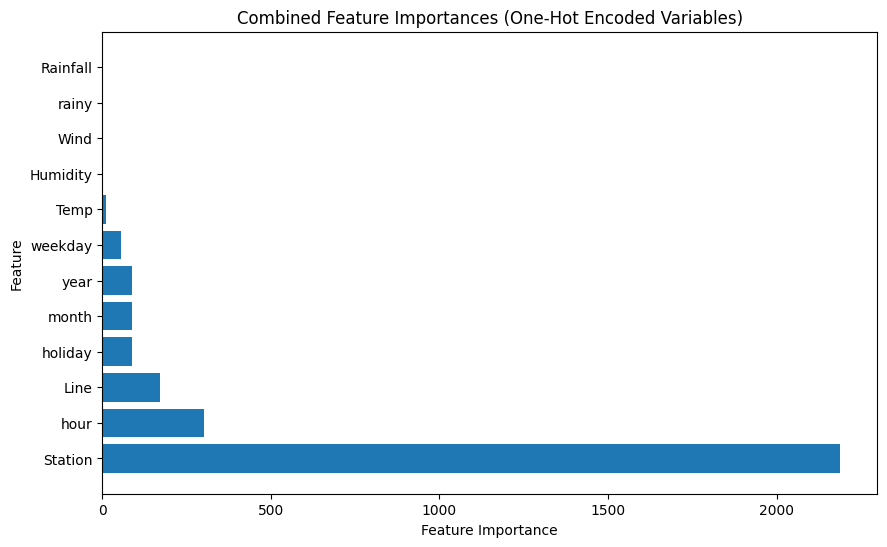

In [18]:
# Train the LGBMRegressor model
LGBM_model = LGBMRegressor(random_state=42)
LGBM_model.fit(X_train, Y_train)

# Get feature importances
feature_importances = LGBM_model.feature_importances_

# Get original feature names (without one-hot encoding)
original_feature_names = [col.split('_')[0] for col in X_train.columns]

# Create a dictionary to store the combined feature importances
combined_feature_importances = {}

# Iterate over the feature importances and sum them for the original feature names
for feature_name, importance in zip(X_train.columns, feature_importances):
    original_feature_name = feature_name.split('_')[0]
    if original_feature_name in combined_feature_importances:
        combined_feature_importances[original_feature_name] += importance
    else:
        combined_feature_importances[original_feature_name] = importance

# Convert the combined feature importances dictionary to a DataFrame
importance_df = pd.DataFrame.from_dict(combined_feature_importances, orient='index', columns=['Importance'])
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(importance_df)), importance_df['Importance'], align='center')
plt.yticks(range(len(importance_df)), importance_df.index)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Combined Feature Importances (One-Hot Encoded Variables)')
plt.show()